In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from smld.signalsamplers import circulant, align

In [2]:
device = "cpu"
loadidx_list = list(range(1, 21))

# Choose the type of diffusion score model.
# Also set correct signal length and maximal diffusion sigma.
scoremodel_type = "learned" # "gaussian", "learned"
length = 41
diffusion_sigma = 3.0

# MRA parameters
MRA_sigma = 10.
M_vals = [int(10**(n/2)) for n in range(4, 13)] 

# If learned diffusion model, set parameters.
MODEL_PATH = "./../../model_weights/smld/" 
learned_model_type = "conv" # "conv", "mlp"
hidden_layers = 8
hidden_dim = 4
embed_dim = 64
signal_sampler_type = "bell" # "hat", "loop", "mlt", "bell"
# type_addendum = "_2"
type_addendum = "_(big)"
signal_scale = 3.0
signal_center = True

use_alt_posterior = False
MODEL_PATH_2 = MODEL_PATH + "_".join((
    f"conv",
    f"len{length}",
    f"lay8",
    f"hid4",
    f"emb64",
    f"sgm3.0",
    f"bell3.0",
    f"cntTrue",
)) + "/"
alt_signal_sampler_typ = "bell_(hat)"

# Set path where figs will be saved.
FIG_PATH = "./../figs/smld/" # NOT LOCATION SAFE
assert os.path.exists(FIG_PATH), "FIG_PATH must exist."



In [3]:
model_name = "_".join((
    f"{learned_model_type}",
    f"len{length}",
    f"lay{hidden_layers}",
    f"hid{hidden_dim}",
    f"emb{embed_dim}",
    f"sgm{diffusion_sigma}",
    f"{signal_sampler_type}{signal_scale}",
    f"cnt{signal_center}",
))
MODEL_PATH += f"{model_name}/"
if not os.path.exists(MODEL_PATH): 
    print(f"Got an invalid {MODEL_PATH = }")
else:
    print(f"True signal will be loaded from {MODEL_PATH}")

signal_true = torch.load(MODEL_PATH+"signal_example.pt", weights_only=True).to(device)

True signal will be loaded from ./../../model_weights/smld/conv_len41_lay8_hid4_emb64_sgm3.0_bell3.0_cntTrue/


In [4]:
aligned_posterior_ests = []
aligned_posterior2_ests = []
signal_aligned_IPSs = []
signal_aligned_OPMs = []
signal_aligned_EMs = []
posterior_est_rmsds = []
posterior2_est_rmsds = []
signal_IPS_rmsds = []
signal_OPM_rmsds = []
signal_EM_rmsds = []
for M in M_vals:
    aligned_posterior_est_list = []
    aligned_posterior2_est_list = []
    signal_aligned_IPS_list = []
    signal_aligned_OPM_list = []
    signal_aligned_EM_list = []
    posterior_est_rmsd_list = []
    posterior2_est_rmsd_list = []
    signal_IPS_rmsd_list = []
    signal_OPM_rmsd_list = []
    signal_EM_rmsd_list = []
    for loadidx in loadidx_list:
        LOAD_PATH = MODEL_PATH+f"runs/{signal_sampler_type}{type_addendum}/{M}_samples/run_{loadidx}/"
        LOAD_PATH_2 = MODEL_PATH_2+f"runs/{alt_signal_sampler_typ}/{M}_samples/run_{loadidx}/"
        if not os.path.exists(LOAD_PATH):
            raise ValueError
        aligned_posterior_est_list.append(torch.load(
            LOAD_PATH+"aligned_posterior_est_list.pt",
            map_location=torch.device('cpu'),
        ))
        signal_aligned_IPS_list.append(torch.load(
            LOAD_PATH+"signal_aligned_IPS_list.pt",
            map_location=torch.device('cpu'),
        ))
        signal_aligned_OPM_list.append(torch.load(
            LOAD_PATH+"signal_aligned_OPM_list.pt",
            map_location=torch.device('cpu'),
        ))
        signal_aligned_EM_list.append(torch.load(
            LOAD_PATH+"signal_aligned_EM_list.pt",
            map_location=torch.device('cpu'),
        ))
        posterior_est_rmsd_list.append(torch.load(
            LOAD_PATH+"posterior_est_rmsd_list.pt",
            map_location=torch.device('cpu'),
        ))
        signal_IPS_rmsd_list.append(torch.load(
            LOAD_PATH+"signal_IPS_rmsd_list.pt",
            map_location=torch.device('cpu'),
        ))
        signal_OPM_rmsd_list.append(torch.load(
            LOAD_PATH+"signal_OPM_rmsd_list.pt",
            map_location=torch.device('cpu'),
        ))
        signal_EM_rmsd_list.append(torch.load(
            LOAD_PATH+"signal_EM_rmsd_list.pt",
            map_location=torch.device('cpu'),
        ))
        if use_alt_posterior:
            aligned_posterior2_est_list.append(torch.load(
                LOAD_PATH_2+"aligned_posterior_est_list.pt",
                map_location=torch.device('cpu'),
            ))
            posterior2_est_rmsd_list.append(torch.load(
                LOAD_PATH_2+"posterior_est_rmsd_list.pt",
                map_location=torch.device('cpu'),
            ))
    aligned_posterior_ests.append(torch.stack(aligned_posterior_est_list))
    signal_aligned_IPSs.append(torch.stack(signal_aligned_IPS_list))
    signal_aligned_OPMs.append(torch.stack(signal_aligned_OPM_list))
    signal_aligned_EMs.append(torch.stack(signal_aligned_EM_list))
    posterior_est_rmsds.append(torch.stack(posterior_est_rmsd_list))
    signal_IPS_rmsds.append(torch.stack(signal_IPS_rmsd_list))
    signal_OPM_rmsds.append(torch.stack(signal_OPM_rmsd_list))
    signal_EM_rmsds.append(torch.stack(signal_EM_rmsd_list))
    if use_alt_posterior:
        aligned_posterior2_ests.append(torch.stack(aligned_posterior2_est_list))
        posterior2_est_rmsds.append(torch.stack(posterior2_est_rmsd_list))
aligned_posterior_ests = torch.stack(aligned_posterior_ests).to(device)
signal_aligned_IPSs = torch.stack(signal_aligned_IPSs).to(device)
signal_aligned_OPMs = torch.stack(signal_aligned_OPMs).to(device)
signal_aligned_EMs = torch.stack(signal_aligned_EMs).to(device)
posterior_est_rmsds = torch.stack(posterior_est_rmsds).to(device)
signal_IPS_rmsds = torch.stack(signal_IPS_rmsds).to(device)
signal_OPM_rmsds = torch.stack(signal_OPM_rmsds).to(device)
signal_EM_rmsds = torch.stack(signal_EM_rmsds).to(device)
if use_alt_posterior:
    aligned_posterior2_ests = torch.stack(aligned_posterior2_ests).to(device)
    posterior2_est_rmsds = torch.stack(posterior2_est_rmsds).to(device)

/tmp/ipykernel_66028/659137773.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  aligned_posterior_est_list.append(torch.load(
/tmp/ipykernel_66028/659137773.py:31: Futur

In [5]:
posterior_est_diffnorm_avg = posterior_est_rmsds.mean(dim=1)
signal_IPS_diffnorm_avg = signal_IPS_rmsds.mean(dim=1)
signal_OPM_diffnorm_avg = signal_OPM_rmsds.mean(dim=1)
signal_EM_diffnorm_avg = signal_EM_rmsds.mean(dim=1)
if use_alt_posterior:
    posterior2_est_diffnorm_avg = posterior2_est_rmsds.mean(dim=1)


In [6]:
true_mean = -signal_true.min()
signal_true = signal_true+true_mean
true_norm = signal_true.square().sum().sqrt()/np.sqrt(length)
# true_norm = signal_true.square().sum().sqrt()
# true_norm = 1.

In [7]:
print(posterior_est_diffnorm_avg)
if use_alt_posterior:
    print(posterior2_est_diffnorm_avg)

tensor([0.4890, 0.4975, 0.4794, 0.4471, 0.3654, 0.2746, 0.2387, 0.2278, 0.2152])


In [8]:
## Visualization

# Hyperparameters for plotting
plot_fontsize = 18
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Times",
    "font.size": plot_fontsize,
})

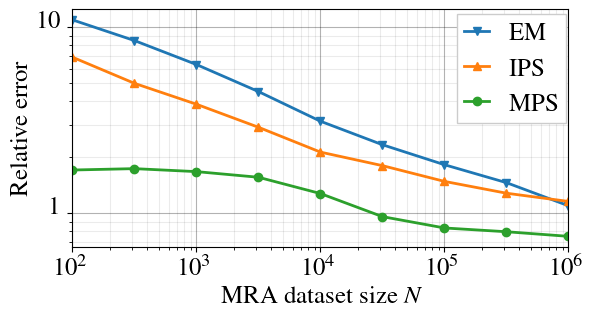

In [12]:
if len(M_vals) > 1:
    fig_l, ax_l = plt.subplots()
    ax_l.loglog(
        M_vals, 
        signal_EM_diffnorm_avg/true_norm,
        color="tab:blue",
        linewidth=2,
        marker="v",
    )
    ax_l.loglog(
        M_vals, 
        signal_IPS_diffnorm_avg/true_norm,
        color="tab:orange",
        linewidth=2,
        marker="^",
    )
    if use_alt_posterior:
        ax_l.loglog(
            M_vals, 
            posterior2_est_diffnorm_avg/true_norm,
            color="tab:purple",
            linewidth=2,
            marker="s",
        )
    ax_l.loglog(
        M_vals, 
        posterior_est_diffnorm_avg/true_norm,
        color="tab:green",
        linewidth=2,
        marker="o",
    )
    if use_alt_posterior:
        legend_list = ["EM", "IPS", "MPS (mis)", "MPS (corr)"]
        ax_l.legend(
            legend_list,
            fontsize=plot_fontsize, 
            loc='upper right', 
            fancybox=False,
            framealpha=1.,
            bbox_to_anchor=(1.021, 1.03, 0, 0),
            borderpad=0.3,
            handlelength=1.,
            ncols=2,
            columnspacing=1.0,
        )
    else:
        legend_list = ["EM", "IPS", "MPS"]
        ax_l.legend(
            legend_list,
            fontsize=plot_fontsize, 
            loc='upper right', 
            fancybox=False,
            framealpha=1.,
            bbox_to_anchor=(1.021, 1.03, 0, 0),
            borderpad=0.3,
            handlelength=1.,
        )
    
    ax_l.set_xlim(10**2, 10**6)
    # ax_l.set_ylim()
    ax_l.set_ylabel("Relative error")
    ax_l.set_xlabel("MRA dataset size~$N$")
    ax_l.grid(which="major", color="k", alpha=0.3)
    ax_l.grid(which="minor", color="k", alpha=0.08)
    # ax_l.set_yticks([0.1, 1])
    # ax_l.set_yticklabels(["0.1", "1"]) 
    ax_l.set_yticks([1, 10])
    ax_l.set_yticklabels(["1", "10"])
    for tick in ax_l.yaxis.get_majorticklabels():
        tick.set_verticalalignment("baseline")
    ax_l.set_aspect(1.5)
    # fig_l.tight_layout()
    plt.savefig(FIG_PATH + f'errloglog_{signal_sampler_type}.png')
    plt.savefig(FIG_PATH + f'errloglog_{signal_sampler_type}.pdf')

In [10]:
roll_num = 38
plotidx = 18
EM_offset_idx = 0
IPS_offset_idx = 0

# roll_num = 20
# plotidx = 17
# EM_offset_idx = -15
# IPS_offset_idx = 2

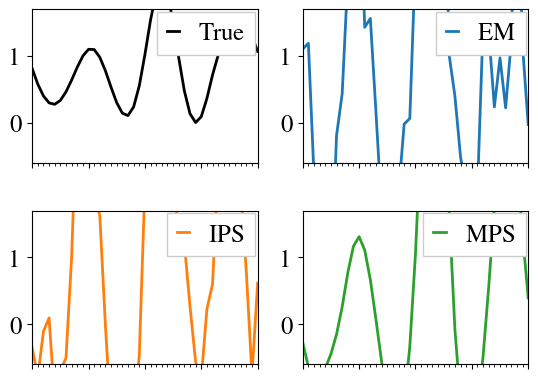

In [11]:
fig_s, ((ax_s11, ax_s12), (ax_s21, ax_s22)) = plt.subplots(2, 2)
axes_s = ((ax_s11, ax_s12), (ax_s21, ax_s22))

ax_s11.plot(
    (signal_true.roll(roll_num))/true_norm, 
    c='k', 
    linewidth=2,
    zorder=2,
)
ax_s12.plot(
    (true_mean+align(signal_aligned_EMs[-1, plotidx+EM_offset_idx, :], signal_true).roll(roll_num))/true_norm, 
    color="tab:blue",
    # linestyle="dotted", 
    linewidth=2,
    zorder=1,
)
ax_s21.plot(
    (true_mean+align(signal_aligned_IPSs[-1, plotidx+IPS_offset_idx, :], signal_true).roll(roll_num))/true_norm, 
    color="tab:orange",
    # linestyle="dotted", 
    linewidth=2,
    zorder=1,
)
ax_s22.plot(
    (true_mean+align(aligned_posterior_ests[-1, plotidx, :], signal_true).roll(roll_num))/true_norm, 
    color="tab:green",
    # linestyle="dashed", 
    linewidth=2, 
    zorder=2,
)

# ylim_s = [-0.7, 2.7]
# yticks_s = [0, 1, 2]
ylim_s = [-0.6, 1.7]
yticks_s = [0, 1]
yticklabels_col0 = yticks_s
yticklabels_col1 = yticklabels_col0
xticklabels_s = []
legendstrings_s = [["True", "EM"], ["IPS", "MPS"]]
for row_idx, axes_row in enumerate(axes_s):
    for col_idx, ax_rowcol in enumerate(axes_row):
        ax_rowcol.set_ylim(ylim_s[0], ylim_s[1])
        ax_rowcol.set_yticks(yticks_s)
        if col_idx == 0:
            ax_rowcol.set_yticklabels(yticklabels_col0)
        else:
            ax_rowcol.set_yticklabels(yticklabels_col1)
        ax_rowcol.set_xlim(0, signal_true.shape[0]-1)
        ax_rowcol.set_xticks(range(0, signal_true.shape[0], 10))
        ax_rowcol.set_xticks(range(signal_true.shape[0]), minor=True)
        ax_rowcol.set_xticklabels(xticklabels_s)
        ax_rowcol.set_aspect(8*3.4/(ylim_s[1]-ylim_s[0]))
        ax_rowcol.legend(
            [legendstrings_s[row_idx][col_idx]],
            fontsize=plot_fontsize, 
            loc='upper right', 
            bbox_to_anchor=(1.045, 1.065, 0, 0),
            handlelength=0.5,
            fancybox=False,
            framealpha=1.,
        )
# fig_s.tight_layout()
plt.savefig(FIG_PATH + f'subplots_{signal_sampler_type}.png')
plt.savefig(FIG_PATH + f'subplots_{signal_sampler_type}.pdf')